In [17]:
import sys 
import os
lib_path = './lib'
sys.path.insert(0, lib_path)     ## add lib path to sys path 
import pandas as pd
import MultiContagion as mc
import igraph
import random
import numpy as np
from matplotlib import pylab as plt
import scipy.stats
import copy
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

year = 2016
import_path = "./data/adjacency_matrix/"
export_path = "./results/csv_contagionFeb/"
export_fig_path = "./results/fig_contagionFeb/"

define functions

In [18]:
#import the aggregate adjacency matrix
aggregate_am = np.genfromtxt (import_path +'AM4_all_nodes_aggregate'+str(year)+'.csv', delimiter=",")
df_names = pd.read_csv(import_path +'all_country_name4.csv', header=None)
names = list(df_names[0])
Aggregate_g = igraph.Graph.Weighted_Adjacency(list(aggregate_am))
Aggregate_g.vs["name"] = copy.deepcopy(names)

#Import the adjacency matrix and make graphs of all the layers.
cdis_equity_am = np.genfromtxt (import_path +'AM4_all_nodesCDIS-equity'+str(year)+'.csv', delimiter=",")
cdis_equity_g = igraph.Graph.Weighted_Adjacency(list(cdis_equity_am))
cdis_equity_g.vs["name"] = copy.deepcopy(names)

cdis_debt_am = np.genfromtxt (import_path +'AM4_all_nodesCDIS-debt'+str(year)+'.csv', delimiter=",")
cdis_debt_g = igraph.Graph.Weighted_Adjacency(list(cdis_debt_am))
cdis_debt_g.vs["name"] = copy.deepcopy(names)

cpis_equity_am = np.genfromtxt (import_path +'AM4_all_nodesCPIS-equity'+str(year)+'.csv', delimiter=",")
cpis_equity_g = igraph.Graph.Weighted_Adjacency(list(cpis_equity_am))
cpis_equity_g.vs["name"] = copy.deepcopy(names)

cpis_debt_am = np.genfromtxt (import_path +'AM4_all_nodesCPIS-debt'+str(year)+'.csv', delimiter=",")
cpis_debt_g = igraph.Graph.Weighted_Adjacency(list(cpis_debt_am))
cpis_debt_g.vs["name"] = copy.deepcopy(names)

bis_am = np.genfromtxt (import_path +'AM4_all_nodesBIS'+str(year)+'.csv', delimiter=",")
bis_g = igraph.Graph.Weighted_Adjacency(list(bis_am))
bis_g.vs["name"] = copy.deepcopy(names)

G_list = [cdis_equity_g, cdis_debt_g, cpis_equity_g, cpis_debt_g, bis_g]

def countries_starting_num(countries_name_starting, g):
    '''Function takes a list of the strings of countries and returns a list of index of those countries in graph g'''
    c_list = []
    for c in countries_name_starting:
        c_list.append(g.vs["name"].index(c))
    return c_list

def make_thresholds_constant(ti = 0.1, tf = 0.8 , steps = 5, layers = 5):
    '''returns list of constantly changing thresholds'''
    T = []
    for t in np.linspace(ti, tf, steps):
        T.append([round(t, 2), [round(t, 2) for i in range(layers)]])
    return T

def multiplex_percolation(G_list, save_name, threshold_intralayer, intercont_function , in_strength_li, in_strength_global_i, param = 1. ,chosen_countrylayer = [[-1, -1]],count_break = 1e3):
    '''Threshold model for multiplex networks - including monoplex. Takes a list of graphs, a threshold list
    for the intralayer contagion and a function for interlayer contagion. This function can depend on a parameter
    (param) local instregth (in_strength_li) and/or glboal (in_strength_global_i). The contagion initial condition is
    given by a list of node-layer lists.'''

    n_layers = len(G_list)

    AM_weight = [G.get_adjacency(attribute="weight") for G in G_list]
    max_countries = max([len(AM_weight[l][0]) for l in range(n_layers)]) #Layers should have same number of nodes, just in case take the maximun.

    if len(chosen_countrylayer) != len(chosen_countrylayer):
        print ("warning chosen_countrylist has differnet length than chosen_layerlist")

    susceptible = [[i for i in range(max_countries)] for l in range(n_layers)] #first index is layer, second give country
    infected = [  [[]]  for i in range(n_layers) ] #first index is layer, second time, third countries

    chosen_countrylayer_copy = copy.deepcopy(chosen_countrylayer) #avoid overwriting global variables
    chose_layer_copy = copy.deepcopy(chosen_countrylayer)

    f = open(save_name+"-IntraThresh"+str(threshold_intralayer[0])+str(year)+".csv", "w")
    f.write("time step, layer, countries that become infected \n")



    for cl in range(len(chosen_countrylayer_copy)): #set default to random if not specified
        if chosen_countrylayer_copy[cl][0] == -1:
            chosen_countrylayer_copy[cl][0] = random.choice(susceptible[0])
        if chosen_countrylayer_copy[cl][1] == -1:
            chosen_countrylayer_copy[cl][1] = random.choice([i for i in xrange(n_layers)])

        #set initial conditions in the list of susceptible and infected nodes.
        l = chosen_countrylayer_copy[cl][1]
        c = chosen_countrylayer_copy[cl][0]
        susceptible[l].remove(c)
        infected[l][0].append(c)
        f.write(str(0) +","+str(l) +","+ G_list[l].vs["name"][c]+ "\n")

    count = 0 #counter taken just as a precaution

    seed_country_name = G_list[l].vs["name"][chosen_countrylayer_copy[cl][0]]
    layer_name = ["CDISeq", "CDISdt", "CPISeq", "CPISdt", "BIS"][chosen_countrylayer_copy[cl][1]]

    for t in range(int(count_break)): #maximun number of steps simulation can have, above number of countries implies bug.

        for l in range(n_layers):
            infected[l].append([])

            for i in infected[l][count]: #nodes that were infected in previous time steps will continue to be infected
                if i not in infected[l][count + 1]:
                            infected[l][count + 1].append(i)

            n_countries = len(AM_weight[l][0])

            for i in susceptible[l]: #for suceptible nodes check if they will be infected by...
                weights_infected_neigh = 0
                already_infected = False

                #infection comming from another layer
                for temp_l in range(n_layers):
                    if temp_l != l:
                        if i in infected[temp_l][count]:

                            if intercont_function(i, l, temp_l, in_strength_li, in_strength_global_i, tau = param)  and i not in infected[l][count + 1]:
                                infected[l][count + 1].append(i)

                                susceptible[l].remove(i)
                                already_infected = True
                #infection from the layer it is in
                if not already_infected: #if it is not infected by layer coupling becoming infected depends on its neighbors

                        if in_strength_li[l][i] == 0: #avoid division by 0, there may be nodes with in_str = 0
                                pass
                        else:

                            in_neigh_list = G_list[l].vs[i].neighbors(mode = "IN")
                            for j in range(len(in_neigh_list)):
                                graph_index = in_neigh_list[j].index

                                if graph_index in infected[l][count]:
                                    weights_infected_neigh +=AM_weight[l][graph_index][i]

                            frac_weight_inf_neigh = float(weights_infected_neigh)/in_strength_li[l][i]


                            if frac_weight_inf_neigh > threshold_intralayer[l]:
                                if i not in infected[l][count + 1]:
                                    infected[l][count + 1].append(i)
                                    susceptible[l].remove(i)
                                    f.write(str(t + 1) +","+str(l) +","+ G_list[l].vs["name"][i]+ "\n")

        count += 1
        boul = False
        for k in range(n_layers):
            if susceptible[k] != []:
                boul = False
                break
            else:

                boul = True

        if boul:
            break

        for k in range(n_layers):
            if len(infected[k][t]) != len(infected[k][t + 1]): #break when there is no update

                boul = False
                break
            else:
                boul = True

        if boul:
            #print "boul break"
            break

        if count == count_break - 5:
            print ("warning, count break")
            break
    f.close()
    return infected#, susceptible

def inter_contagion_layer_to_layer_instr_ratio(node, susceptible_lay, infected_lay, in_strength, in_strength_global_i, tau = 1.):
    '''Rule for contagion between layer is instregth of infected layer vs instregth of suceptible layer'''
    if float(in_strength[infected_lay][node]) > tau*in_strength[susceptible_lay][node]:
        return True
    else:
        return False

def inter_contagion_layer_to_global_instr_ratio(node, susceptible_lay, infected_lay, in_strength, in_strength_global_i, tau = 1./3.):
    '''Rule for contagion between layers is the instrenth of infected layer vs '''
    if float(in_strength[infected_lay][node])/in_strength_global_i[node] > tau:
        return True
    else:
        return False

def inter_contagion_layer_to_layer_instant(node, susceptible_lay, infected_lay, in_strength, in_strength_global_i, tau = 1.):
    return True


In [19]:

countries_name_starting = ["United States", "United Kingdom", "Netherlands", "Luxembourg", "China  P.R.: Hong Kong", "Germany", "France", "China  P.R.: Mainland" ]
countries_starting = countries_starting_num(countries_name_starting, Aggregate_g)

in_strengthli = [G.strength(weights=G.es["weight"], mode = "IN") for G in G_list]
in_strengthli_agg = [G.strength(weights=G.es["weight"], mode = "IN") for G in [Aggregate_g]]

n_nodes = len(G_list[0].vs["name"])
in_strength_total = [0 for i in range(n_nodes)]
n_layers = len(G_list)
for kappa in range(n_nodes):
    for lay in range(n_layers):
        in_strength_total[kappa] += in_strengthli[lay][kappa]

european_union_name_start = [ "Austria", "Belgium", "Bulgaria", "Croatia", "Cyprus", "Czech Republic", "Denmark", "Estonia", "Finland", "France" , "Germany", "Greece", "Hungary", "Ireland", "Italy", "Latvia", "Lithuania", "Luxembourg", "Malta", "Netherlands", "Poland", "Portugal", "Romania", "Slovak Republic", "Slovenia", "Spain", "Sweden", "United Kingdom" ]
european_union_name_start_uk = [ "Austria", "Belgium", "Bulgaria", "Croatia", "Cyprus", "Czech Republic", "Denmark", "Estonia", "Finland", "France" , "Germany", "Greece", "Hungary", "Ireland", "Italy", "Latvia", "Lithuania", "Luxembourg", "Malta", "Netherlands", "Poland", "Portugal", "Romania", "Slovak Republic", "Slovenia", "Spain", "Sweden"]
important_countres_name_start = ["United States", "United Kingdom", "Netherlands", "Luxembourg", "France", "Germany", "China  P.R.: Hong Kong","China  P.R.: Mainland"]
china_name_start = ["China  P.R.: Hong Kong","China  P.R.: Mainland"]


european_start = countries_starting_num(european_union_name_start, Aggregate_g)
european_start_layer_agg = []
for c in european_start:
    european_start_layer_agg.append([c, 0])
european_start_layer = []
for c in european_start:
    european_start_layer.append([c, 4])

european_start_uk = countries_starting_num(european_union_name_start_uk , Aggregate_g)
european_start_layer_agg_uk  = []
for c in european_start_uk :
    european_start_layer_agg_uk .append([c, 0])
european_start_layer_uk  = []
for c in european_start_uk:
    european_start_layer_uk .append([c, 4])

important_countres_name_start = ["United States", "United Kingdom", "Netherlands", "Luxembourg", "France", "Germany", "China  P.R.: Hong Kong","China  P.R.: Mainland"]
countries_abre_name = ['USA', 'UK', 'Netherlands', 'Luxembourg', 'France', 'Germany', 'Hong Kong SAR', 'China']

important_countres_start = countries_starting_num(important_countres_name_start,Aggregate_g)
important_countres_start_layer_agg = []
for c in important_countres_start:
    important_countres_start_layer_agg.append([c, 0])
important_countres_start_layer = []
for c in important_countres_start:
    important_countres_start_layer.append([c, 4])

china_start = countries_starting_num(china_name_start,Aggregate_g)
china_start_layer_agg = []
for c in china_start:
    china_start_layer_agg.append([c, 0])
china_start_layer = []
for c in china_start:
    china_start_layer.append([c, 4])


important_countres_start_all_layers = []
count = 0
for c in important_countres_start:
    important_countres_start_all_layers.append([])
    for i in range(len(G_list)):
        important_countres_start_all_layers[count].append([c, i])
    count +=1

european_start_all_layer = []
for c in european_start:
    for i in range(len(G_list)):
        european_start_all_layer.append([c, i])

european_start_all_layer_uk = []
for c in european_start_uk:
    for i in range(len(G_list)):
        european_start_all_layer_uk.append([c, i])

china_start_all_layer = []
for c in china_start:
    for i in range(len(G_list)):
        china_start_all_layer.append([c, i])


# In[126]:

Thresholds = make_thresholds_constant(ti = 0.1,tf = 0.99,steps=15) #+ make_thresholds_var_av() + make_thresholds_var_av(ti = 0.4, tf = 0.6)
S_agg = []
S_multi2 = []
S_multi1 = []
name1 = []
T_1 = []
count = 0
n_lay = 5
#Aggregate_g.vs["name"][43] = "China  P.R.: Hong Kong"


In [20]:
def make_thresholds_constant(ti = 0.1, tf = 0.8 , steps = 5, layers = 5):
    '''returns list of constantly changing thresholds'''
    T = []
    for t in np.linspace(ti, tf, steps):
        T.append([round(t, 2), [round(t, 2) for i in range(layers)]])
    return T

In [21]:
len(Thresholds)

15

In [22]:
#Doing a small grid threshold list
Thresholds = make_thresholds_constant(ti = 0.1,tf = 0.95,steps=18)
# countries in the small grid + 2, (EU and EU\UK)
n_entities = len(important_countres_name_start) + 2
#making the grid
grid_agg = np.zeros([n_entities, len(Thresholds)])
grid_multi = np.zeros([n_entities, len(Thresholds)])

United States


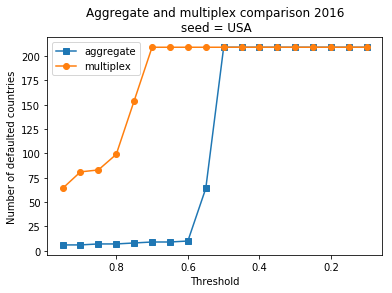

United Kingdom


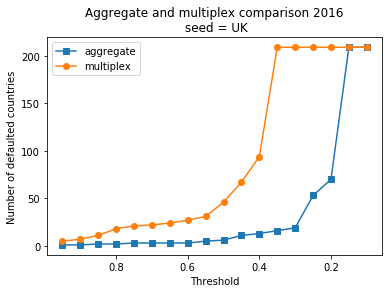

Netherlands


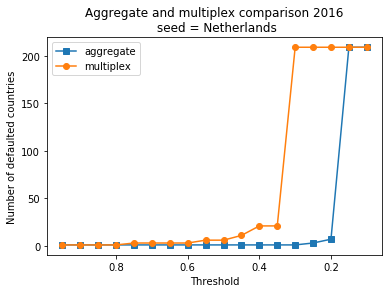

Luxembourg


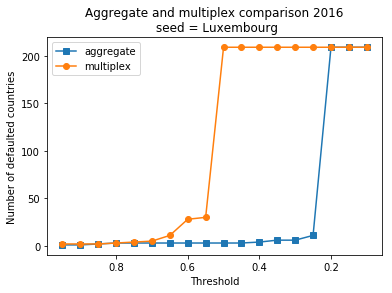

France


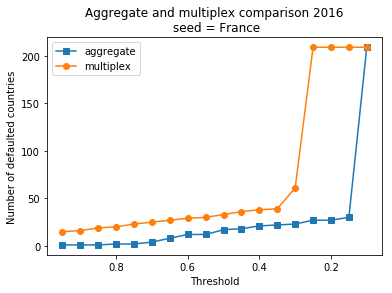

Germany


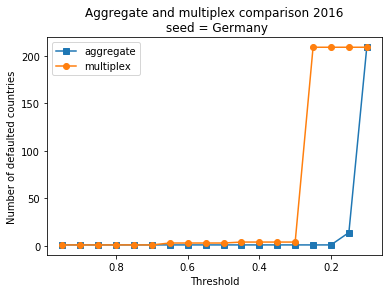

China  P.R.: Hong Kong


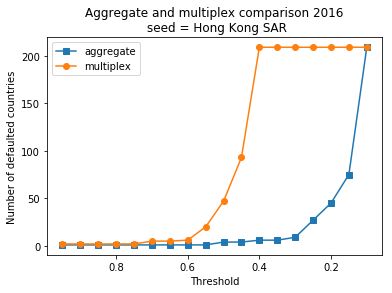

China  P.R.: Mainland


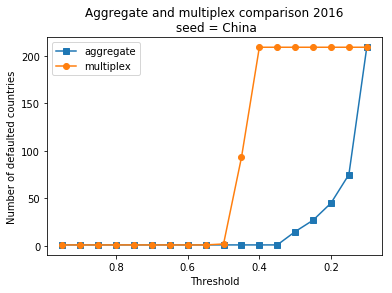

In [23]:
#Doing a small grid threshold list
Thresholds = make_thresholds_constant(ti = 0.1,tf = 0.95,steps=18)

aff_lay = 4
layer_name = ["CDISeq", "CDISdt", "CPISeq", "CPISdt", "BIS"]
affected =[]
count1 = -1
for i in range(len(important_countres_start_all_layers)):#start percolation with a given seed node.
    fig = plt.figure()
    ax = plt.subplot(111)
    country_name = Aggregate_g.vs["name"][important_countres_start_layer[i][0]] #All layers and aggregate have same nodes (isolated were not removed)
    lay_ini = layer_name[important_countres_start_layer[i][1]]
    name1.append(country_name )
    print(country_name)
    s_agg = []
    s_multi1 = []
    s_multi2 = []
    T_1 = []
    affected.append([])
    count1 += 1
    for T in Thresholds:

        perco = multiplex_percolation([Aggregate_g], export_path+ country_name.replace(':','')  +"-agg", T[1],inter_contagion_layer_to_layer_instr_ratio, in_strengthli_agg , in_strength_total ,param = 1. , chosen_countrylayer= [important_countres_start_layer_agg[i]], count_break= 1000)
        s_agg.append(len(perco[0][-1]))


        percomulti1 = multiplex_percolation(G_list,export_path+ country_name.replace(':','')  +"-multi1-AllLayers" ,T[1], inter_contagion_layer_to_layer_instant, in_strengthli, in_strength_total ,param = 1. , chosen_countrylayer= important_countres_start_all_layers[i], count_break= 1000)
        percomax1 = percomulti1[0][-1]
        resulting_list1 = list(percomulti1[0][-1])
        for l in range(1,n_lay):
            resulting_list1.extend(x for x in percomulti1[l][-1] if x not in resulting_list1)

        s_multi1.append(len(resulting_list1))
        affected[count1].append(percomulti1[0][-1])

        #percomulti2 = multiplex_percolation(G_list,export_path+ country_name  +"-multi2-AllLayers" ,T[1], inter_contagion_layer_to_layer_instr_ratio, in_strengthli, in_strength_total ,param = 1. , chosen_countrylayer= important_countres_start_all_layers[i], count_break= 1000)
        #percomax2 = percomulti2[0][-1]
        #resulting_list2 = list(percomulti2[0][-1])
        #for l in range(1,n_lay):
            #resulting_list2.extend(x for x in percomulti2[l][-1] if x not in resulting_list2)

        #s_multi2.append(len(resulting_list2))
        #affected[count1].append(percomulti2[0][-1])

        T_1.append(T[0])

    S_agg.append(s_agg)
    S_multi1.append(s_multi1)
    grid_agg[i, :] = copy.deepcopy(s_agg)
    grid_multi[i, :] = copy.deepcopy(s_multi1)
    #S_multi2.append(s_multi2)

    #Lines to save number of affected countries per layer
    f_agg = open( export_path+ 'AggNumAffected_seed' + country_name.replace(':','') + str(year) + '.csv', 'w' )
    f_multi1 = open(export_path + 'MultAllLayNumAffected_seed' + country_name.replace(':','') + str(year) + '.csv', 'w' )
    f_agg.write("Threshold,Number of Affected Countries \n")
    f_multi1.write("Threshold,Number of Affected Countries \n")
    for j in range(len(T_1)):
        f_agg.write(str(T_1[j]) + ',' + str(s_agg[j]) + '\n')
        f_multi1.write(str(T_1[j]) + ',' + str(s_multi1[j]) + '\n')
    f_agg.close()
    f_multi1.close()

    #print len(T_1), len(s_agg)
    #Uncomment following lines depending on which lines you want to plot
    plt.plot(T_1, s_agg, "s-", label = "aggregate")
    plt.plot(T_1, s_multi1, "o-", label = "multiplex")
    #plt.plot(T_1, s_multi2, "^-", label = "multiplex2")

    plt.title("Aggregate and multiplex comparison "+str(year) +  "\n seed = "+ countries_abre_name[i] )
    plt.xlabel("Threshold")
    plt.ylabel("Number of defaulted countries")
    box = ax.get_position()
    #ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Put a legend to the right of the current axis
    #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.legend(loc='upper left')
    plt.gca().invert_xaxis()
    plt.savefig(export_fig_path+"ContagionAllLayers"+ country_name.replace(':','')+str(year)+".png", bbox_inches="tight")
    plt.show()
    count += 1



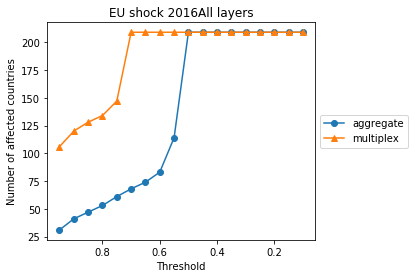

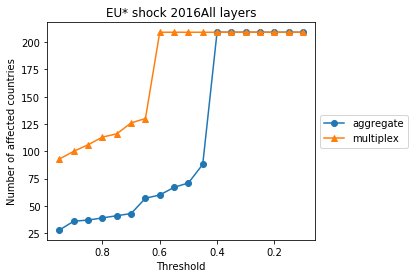

In [24]:
# ## EU shock all layers

Thresholds = make_thresholds_constant(ti = 0.1,tf = 0.99,steps=15) #+ make_thresholds_var_av() + make_thresholds_var_av(ti = 0.4, tf = 0.6)
#Doing a small grid threshold list
Thresholds = make_thresholds_constant(ti = 0.1,tf = 0.95,steps=18)
s_agg = []
s_multi1 = []
s_multi2 = []
s_multi3 = []
fig = plt.figure()
ax = plt.subplot(111)
n_lay = 5
T_plot = []
for T in Thresholds:

    perco = multiplex_percolation([Aggregate_g], export_path+"EU-shock-agg", T[1],inter_contagion_layer_to_layer_instr_ratio, in_strengthli_agg , in_strength_total ,param = 1. , chosen_countrylayer= european_start_layer_agg, count_break= 1000)
    s_agg.append(len(perco[0][-1]))

    percomulti2 = multiplex_percolation(G_list, export_path+"EU-shock-multiplex1-AllLayers", T[1], inter_contagion_layer_to_layer_instr_ratio, in_strengthli, in_strength_total ,param = 1. , chosen_countrylayer= european_start_all_layer, count_break= 1000)
    percomulti1 = multiplex_percolation(G_list, export_path+"EU-shock-multiplex1-AllLayers", T[1], inter_contagion_layer_to_layer_instant, in_strengthli, in_strength_total ,param = 1. , chosen_countrylayer= european_start_all_layer, count_break= 1000)
    #percomulti3 = multiplex_percolation(G_list, T[1], inter_contagion_layer_to_global_instr_ratio, in_strengthli, in_strength_total ,param = 1./3. , chosen_countrylayer= european_start_layer, count_break= 1000)


    percomax1 = percomulti1[0][-1]
    resulting_list1 = list(percomulti1[0][-1])
    for l in range(1,n_lay):
        resulting_list1.extend(x for x in percomulti1[l][-1] if x not in resulting_list1)
    s_multi1.append(len(resulting_list1))

    percomax2 = percomulti2[0][-1]
    resulting_list2 = list(percomulti2[0][-1])
    for l in range(1,n_lay):
        resulting_list2.extend(x for x in percomulti2[l][-1] if x not in resulting_list2)
    s_multi2.append(len(resulting_list2))

    #percomax3 = percomulti3[0][-1]
    #resulting_list3 = list(percomulti3[0][-1])
    #for l in range(1,n_lay):
    #    resulting_list3.extend(x for x in percomulti3[l][-1] if x not in resulting_list3)
    #s_multi3.append(len(resulting_list3))

    T_plot.append(T[0])
f_agg = open( export_path+ 'AggNumAffected_seed' + 'EU' + str(year) + '.csv', 'w' )
f_multi1 = open(export_path + 'MultAllLayNumAffected_seed' + 'EU' + str(year) + '.csv', 'w' )
f_agg.write("Threshold,Number of Affected Countries \n")
f_multi1.write("Threshold,Number of Affected Countries \n")
for i in range(len(T_plot)):
    f_agg.write(str(T_plot[i]) + ',' + str(s_agg[i]) + '\n')
    f_multi1.write(str(T_plot[i]) + ',' + str(s_multi1[i]) + '\n')
f_agg.close()
f_multi1.close()

plt.plot( T_plot,s_agg,"o-", label = "aggregate")
plt.plot( T_plot, s_multi1,"^-", label = "multiplex")
#plt.plot( T_plot, s_multi2,"*-", label = "multiplex2")

#add to grid
grid_agg[n_entities - 2, :] = copy.deepcopy(s_agg)
grid_multi[n_entities - 2, :] = copy.deepcopy(s_multi1)

#plt.plot( T_plot, s_multi3,"s-", label = "multiplex3")
plt.title("EU shock "+str(year) + "All layers" )
plt.xlabel("Threshold")
plt.ylabel("Number of affected countries")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.gca().invert_xaxis()
plt.savefig(export_fig_path+"ContagionAllLayers"+"EU"+str(year)+".png")
#plt.show()

# ## EU shock all layers - UK

Thresholds = make_thresholds_constant(ti = 0.1,tf = 0.99,steps=15) #+ make_thresholds_var_av() + make_thresholds_var_av(ti = 0.4, tf = 0.6)
#Doing a small grid threshold list
Thresholds = make_thresholds_constant(ti = 0.1,tf = 0.95,steps=18)
s_agg = []
s_multi1 = []
s_multi2 = []
s_multi3 = []
fig = plt.figure()
ax = plt.subplot(111)
n_lay = 5
T_plot = []
for T in Thresholds:

    perco = multiplex_percolation([Aggregate_g], export_path+"EU-shock-agg-uk", T[1],inter_contagion_layer_to_layer_instr_ratio, in_strengthli_agg , in_strength_total ,param = 1. , chosen_countrylayer= european_start_layer_agg_uk, count_break= 1000)
    s_agg.append(len(perco[0][-1]))

    percomulti2 = multiplex_percolation(G_list, export_path+"EU-shock-multiplex1-AllLayers-uk", T[1], inter_contagion_layer_to_layer_instr_ratio, in_strengthli, in_strength_total ,param = 1. , chosen_countrylayer= european_start_all_layer_uk, count_break= 1000)
    percomulti1 = multiplex_percolation(G_list, export_path+"EU-shock-multiplex1-AllLayers-uk", T[1], inter_contagion_layer_to_layer_instant, in_strengthli, in_strength_total ,param = 1. , chosen_countrylayer= european_start_all_layer_uk, count_break= 1000)
    #percomulti3 = multiplex_percolation(G_list, T[1], inter_contagion_layer_to_global_instr_ratio, in_strengthli, in_strength_total ,param = 1./3. , chosen_countrylayer= european_start_layer, count_break= 1000)


    percomax1 = percomulti1[0][-1]
    resulting_list1 = list(percomulti1[0][-1])
    for l in range(1,n_lay):
        resulting_list1.extend(x for x in percomulti1[l][-1] if x not in resulting_list1)
    s_multi1.append(len(resulting_list1))

    percomax2 = percomulti2[0][-1]
    resulting_list2 = list(percomulti2[0][-1])
    for l in range(1,n_lay):
        resulting_list2.extend(x for x in percomulti2[l][-1] if x not in resulting_list2)
    s_multi2.append(len(resulting_list2))

    #percomax3 = percomulti3[0][-1]
    #resulting_list3 = list(percomulti3[0][-1])
    #for l in range(1,n_lay):
    #    resulting_list3.extend(x for x in percomulti3[l][-1] if x not in resulting_list3)
    #s_multi3.append(len(resulting_list3))

    T_plot.append(T[0])
f_agg = open( export_path+ 'AggNumAffected_seed' + 'EU-uk' + str(year) + '.csv', 'w' )
f_multi1 = open(export_path + 'MultAllLayNumAffected_seed' + 'EU-uk' + str(year) + '.csv', 'w' )
f_agg.write("Threshold,Number of Affected Countries \n")
f_multi1.write("Threshold,Number of Affected Countries \n")
for i in range(len(T_plot)):
    f_agg.write(str(T_plot[i]) + ',' + str(s_agg[i]) + '\n')
    f_multi1.write(str(T_plot[i]) + ',' + str(s_multi1[i]) + '\n')
f_agg.close()
f_multi1.close()

plt.plot( T_plot,s_agg,"o-", label = "aggregate")
plt.plot( T_plot, s_multi1,"^-", label = "multiplex")
#plt.plot( T_plot, s_multi2,"*-", label = "multiplex2")

#add to grid
grid_agg[n_entities - 1, :] = copy.deepcopy(s_agg)
grid_multi[n_entities - 1, :] = copy.deepcopy(s_multi1)

#plt.plot( T_plot, s_multi3,"s-", label = "multiplex3")
plt.title("EU* shock "+str(year) + "All layers" )
plt.xlabel("Threshold")
plt.ylabel("Number of affected countries")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.gca().invert_xaxis()
plt.savefig(export_fig_path+"ContagionAllLayers"+"EU-uk"+str(year)+".png")
plt.show()


In [25]:
#countries_abre_name

In [26]:
important_countres_name_start
countries_abr = ["USA", "UK", "NL", "LUX", "FRA", "GER", "CHN", "HK", "EU", "EU - UK"]

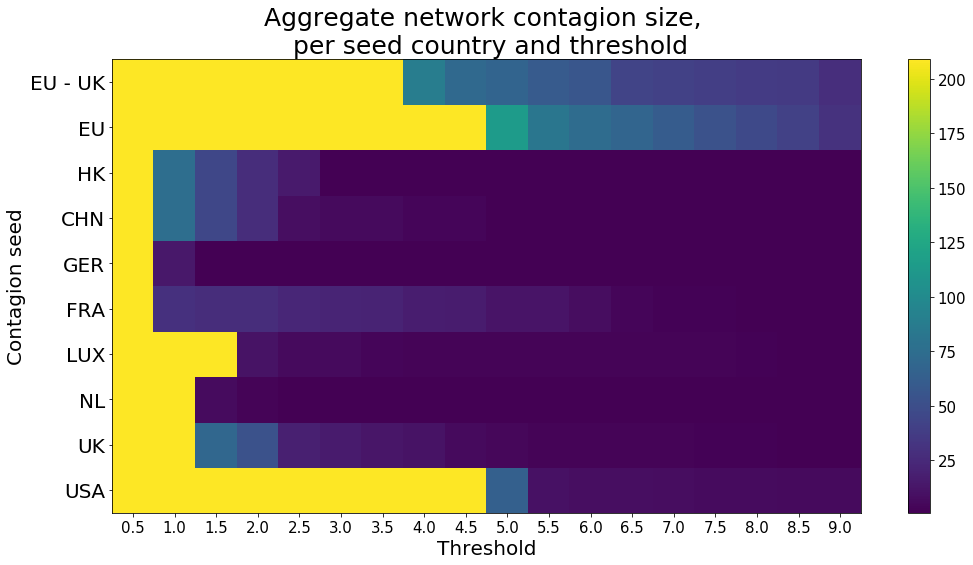

In [27]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.subplots_adjust(bottom=0.25,left=0.25) # make room for labels

heatmap = ax.pcolor(grid_agg)
cbar = plt.colorbar(heatmap)
ax.set_xticks(np.arange(grid_agg.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(grid_agg.shape[0]) + 0.5, minor=False)

#ax.yaxis.set_tick_params(labelsize=20)
#ax.set_xticklabels(headers[1:],rotation=90)
plt.tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=15)
ax.set_xticklabels(str(0.5 + 0.5*i) for i in  range(18))
ax.set_yticklabels(countries_abr)
ax.set_xlabel("Threshold", fontsize=20)
ax.set_ylabel("Contagion seed", fontsize=20)
cbar.ax.tick_params(labelsize=15)
ax.set_title("Aggregate network contagion size, \n per seed country and threshold", fontsize=25)
plt.savefig(export_fig_path + "Aggregate_grid.png")
plt.show()

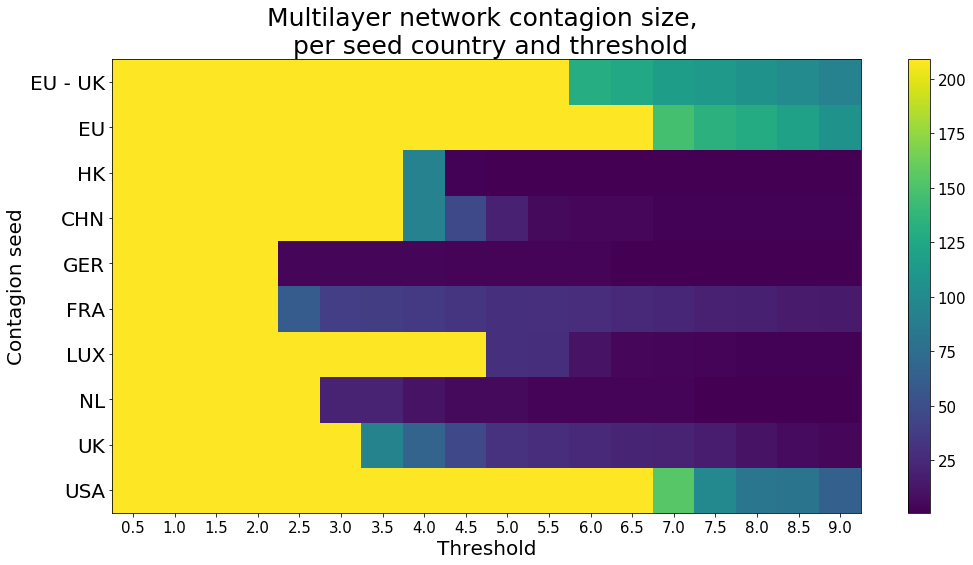

In [28]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.subplots_adjust(bottom=0.25,left=0.25) # make room for labels

heatmap = ax.pcolor(grid_multi)
cbar = plt.colorbar(heatmap)
ax.set_xticks(np.arange(grid_agg.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(grid_agg.shape[0]) + 0.5, minor=False)

plt.tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=15)
ax.set_yticklabels(countries_abr)
ax.set_xticklabels(str(0.5 + 0.5*i) for i in  range(18))
ax.set_xlabel("Threshold", fontsize=20)
ax.set_ylabel("Contagion seed", fontsize=20)
cbar.ax.tick_params(labelsize=15)
ax.set_title("Multilayer network contagion size, \n per seed country and threshold", fontsize=25)
plt.savefig(export_fig_path + "Multi_grid.png")
plt.show()

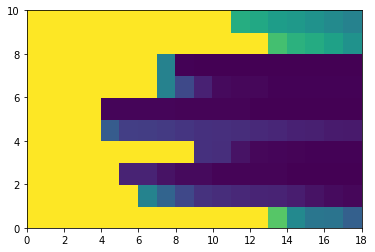

In [29]:
headers = important_countres_name_start
fig, ax1 = plt.subplots(1,1)
ax1.pcolor(grid_multi)
#plt.colorbar()

In [30]:
important_countres_name_start

['United States',
 'United Kingdom',
 'Netherlands',
 'Luxembourg',
 'France',
 'Germany',
 'China  P.R.: Hong Kong',
 'China  P.R.: Mainland']

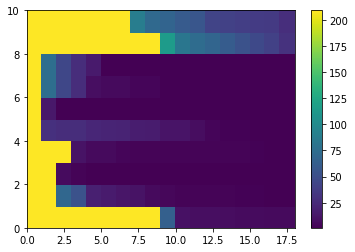

In [31]:
plt.pcolor(grid_agg)
plt.colorbar()

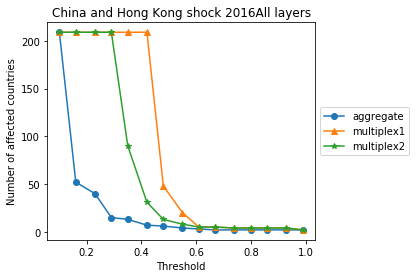

In [32]:

# ## China Shock All Layers

Thresholds = make_thresholds_constant(ti = 0.1,tf = 0.99,steps=15) #+ make_thresholds_var_av() + make_thresholds_var_av(ti = 0.4, tf = 0.6)
s_agg = []
s_multi1 = []
s_multi2 = []
s_multi3 = []
fig = plt.figure()
ax = plt.subplot(111)
n_lay = 5
T_plot = []
for T in Thresholds:

    perco = multiplex_percolation([Aggregate_g], export_path+"China-shock-agg", T[1],inter_contagion_layer_to_layer_instr_ratio, in_strengthli_agg , in_strength_total ,param = 1. , chosen_countrylayer= china_start_layer_agg, count_break= 1000)
    s_agg.append(len(perco[0][-1]))

    percomulti2 = multiplex_percolation(G_list, export_path+"China-shock-multiplex1-AllLayers", T[1], inter_contagion_layer_to_layer_instr_ratio, in_strengthli, in_strength_total ,param = 1. , chosen_countrylayer= china_start_all_layer, count_break= 1000)
    percomulti1 = multiplex_percolation(G_list, export_path+"China-shock-multiplex1-AllLayers", T[1], inter_contagion_layer_to_layer_instant, in_strengthli, in_strength_total ,param = 1. , chosen_countrylayer= china_start_all_layer, count_break= 1000)
    #percomulti3 = multiplex_percolation(G_list, T[1], inter_contagion_layer_to_global_instr_ratio, in_strengthli, in_strength_total ,param = 1./3. , chosen_countrylayer= european_start_layer, count_break= 1000)


    percomax1 = percomulti1[0][-1]
    resulting_list1 = list(percomulti1[0][-1])
    for l in range(1,n_lay):
        resulting_list1.extend(x for x in percomulti1[l][-1] if x not in resulting_list1)
    s_multi1.append(len(resulting_list1))

    percomax2 = percomulti2[0][-1]
    resulting_list2 = list(percomulti2[0][-1])
    for l in range(1,n_lay):
        resulting_list2.extend(x for x in percomulti2[l][-1] if x not in resulting_list2)
    s_multi2.append(len(resulting_list2))

    #percomax3 = percomulti3[0][-1]
    #resulting_list3 = list(percomulti3[0][-1])
    #for l in range(1,n_lay):
    #    resulting_list3.extend(x for x in percomulti3[l][-1] if x not in resulting_list3)
    #s_multi3.append(len(resulting_list3))

    T_plot.append(T[0])
f_agg = open( export_path+ 'AggNumAffected_seed' + 'China' + str(year) + '.csv', 'w' )
f_multi1 = open(export_path + 'MultAllLayNumAffected_seed' + 'China' + str(year) + '.csv', 'w' )
f_agg.write("Threshold,Number of Affected Countries \n")
f_multi1.write("Threshold,Number of Affected Countries \n")
for i in range(len(T_plot)):
    f_agg.write(str(T_plot[i]) + ',' + str(s_agg[i]) + '\n')
    f_multi1.write(str(T_plot[i]) + ',' + str(s_multi1[i]) + '\n')
f_agg.close()
f_multi1.close()

plt.plot( T_plot,s_agg,"o-", label = "aggregate")
plt.plot( T_plot, s_multi1,"^-", label = "multiplex1")
plt.plot( T_plot, s_multi2,"*-", label = "multiplex2")

#plt.plot( T_plot, s_multi3,"s-", label = "multiplex3")
plt.title("China and Hong Kong shock "+str(year) + "All layers" )
plt.xlabel("Threshold")
plt.ylabel("Number of affected countries")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(export_fig_path+"ContagionAllLayers"+"China"+str(year)+".png")
plt.show()